<a href="https://colab.research.google.com/github/vasanthbhagawat-source/softvoting/blob/main/softvoting_dataset1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# STEP 1: Mount Drive (if using Colab)
from google.colab import drive
import os
import shutil

mountpoint = '/content/drive'

try:
  drive.mount(mountpoint, force_remount=True)
except ValueError:
  print("Google Drive is already mounted. Unmounting and remounting.")
  drive.flush_and_unmount()
  # Check if the directory exists and is not a mount point, then remove it
  if os.path.exists(mountpoint) and not os.path.ismount(mountpoint):
      shutil.rmtree(mountpoint) # Use shutil.rmtree for non-empty directory
  drive.mount(mountpoint, force_remount=True)

Mounted at /content/drive


In [ ]:
# STEP 2: Install Required Packages
!pip install -q keras scikit-learn matplotlib seaborn opencv-python tensorflow

In [ ]:
# STEP 3: Set Paths and Create Result Directory
import os
train_dir = '/content/drive/MyDrive/alex/Brain/Training'
test_dir = '/content/drive/MyDrive/alex/Brain/Testing'
save_dir = '/content/drive/MyDrive/ensembled/brain_tumor_results'
os.makedirs(save_dir, exist_ok=True)

In [ ]:
# STEP 4: Data Augmentation and Preprocessing
from tensorflow.keras.preprocessing.image import ImageDataGenerator

img_size = (224, 224)
batch_size = 32

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    zoom_range=0.2,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    horizontal_flip=True,
    validation_split=0.2
)

test_datagen = ImageDataGenerator(rescale=1./255)

train_gen = train_datagen.flow_from_directory(
    train_dir, target_size=img_size, batch_size=batch_size,
    class_mode='categorical', subset='training'
)

val_gen = train_datagen.flow_from_directory(
    train_dir, target_size=img_size, batch_size=batch_size,
    class_mode='categorical', subset='validation'
)

test_gen = test_datagen.flow_from_directory(
    test_dir, target_size=img_size, batch_size=batch_size,
    class_mode='categorical', shuffle=False
)

Found 4571 images belonging to 4 classes.
Found 1141 images belonging to 4 classes.
Found 1311 images belonging to 4 classes.


In [ ]:
# STEP 5: Define Models
from tensorflow.keras import layers, models
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.optimizers import Adam

input_shape = (224, 224, 3)
num_classes = train_gen.num_classes

def create_cnn():
    model = models.Sequential([
        layers.Conv2D(32, (3,3), activation='relu', input_shape=input_shape),
        layers.MaxPooling2D(),
        layers.Conv2D(64, (3,3), activation='relu'),
        layers.MaxPooling2D(),
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dense(num_classes, activation='softmax')
    ])
    return model

def create_alexnet():
    model = models.Sequential([
        layers.Conv2D(96, (11,11), strides=4, activation='relu', input_shape=input_shape),
        layers.MaxPooling2D(pool_size=(3,3), strides=2),
        layers.Conv2D(256, (5,5), activation='relu', padding='same'),
        layers.MaxPooling2D(pool_size=(3,3), strides=2),
        layers.Conv2D(384, (3,3), activation='relu', padding='same'),
        layers.Conv2D(384, (3,3), activation='relu', padding='same'),
        layers.Conv2D(256, (3,3), activation='relu', padding='same'),
        layers.MaxPooling2D(pool_size=(3,3), strides=2),
        layers.Flatten(),
        layers.Dense(4096, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(4096, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation='softmax')
    ])
    return model

def resnet50():
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)
    for layer in base_model.layers[:-20]:
        layer.trainable = False
    model = models.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.Dense(256, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation='softmax')
    ])
    return model

def create_mesresnet50():
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)
    for layer in base_model.layers[:20]:
        layer.trainable = False
    x = base_model.output
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.5)(x)
    x = layers.Dense(512)(x)
    x = layers.LeakyReLU(alpha=0.1)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.4)(x)
    x = layers.Dense(256, activation='relu')(x)
    x = layers.Dropout(0.3)(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)
    model = models.Model(inputs=base_model.input, outputs=outputs)
    return model

In [ ]:
# STEP 6: Compile & Train Function
def compile_and_train(model, name):
    model.compile(optimizer=Adam(1e-4),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    history = model.fit(train_gen, validation_data=val_gen, epochs=20)
    model.save(f'{save_dir}/{name}.h5')
    return model, history

In [ ]:
#  STEP 7: Train Base Models
models_dict = {}
histories = {}

for name, builder in {
    "CNN": create_cnn,
    "AlexNet": create_alexnet,
    "ResNet50": resnet50,
    "MesResNet50": create_mesresnet50
}.items():
    print(f"\nTraining {name}...")
    model, history = compile_and_train(builder(), name)
    models_dict[name] = model
    histories[name] = history


Training CNN...


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 1482s 10s/step - accuracy: 0.4277 - loss: 1.1980 - val_accuracy: 0.5723 - val_loss: 1.0409
Epoch 2/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 75s 521ms/step - accuracy: 0.6997 - loss: 0.7531 - val_accuracy: 0.6801 - val_loss: 0.9248
Epoch 3/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 70s 493ms/step - accuracy: 0.7512 - loss: 0.6457 - val_accuracy: 0.7108 - val_loss: 0.8883
Epoch 4/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 73s 510ms/step - accuracy: 0.7648 - loss: 0.6123 - val_accuracy: 0.6687 - val_loss: 0.8839
Epoch 5/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 75s 527ms/step - accuracy: 0.7549 - loss: 0.5927 - val_accuracy: 0.7152 - val_loss: 0.8374
Epoch 6/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 75s 524ms/step - accuracy: 0.7884 - loss: 0.5713 - val_accuracy: 0.7108 - val_loss: 0.8394
Epoch 7/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 74s 515ms/step - accuracy: 0.7987 - loss: 0.5361 - val_accuracy: 0.7011 - val_loss: 0.8298
Epoch 8/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 71s 497ms/step - accuracy: 0.7917 - loss: 0


Training AlexNet...
Epoch 1/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 94s 598ms/step - accuracy: 0.3325 - loss: 1.2782 - val_accuracy: 0.5600 - val_loss: 1.0847
Epoch 2/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 74s 519ms/step - accuracy: 0.6616 - loss: 0.7848 - val_accuracy: 0.4847 - val_loss: 1.5043
Epoch 3/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 74s 519ms/step - accuracy: 0.7132 - loss: 0.6710 - val_accuracy: 0.6819 - val_loss: 0.8962
Epoch 4/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 75s 525ms/step - accuracy: 0.7712 - loss: 0.5725 - val_accuracy: 0.7222 - val_loss: 0.7179
Epoch 5/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 75s 523ms/step - accuracy: 0.8123 - loss: 0.4823 - val_accuracy: 0.7581 - val_loss: 0.6623
Epoch 6/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 76s 531ms/step - accuracy: 0.8265 - loss: 0.4315 - val_accuracy: 0.7467 - val_loss: 0.6551
Epoch 7/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 74s 519ms/step - accuracy: 0.8591 - loss: 0.3959 - val_accuracy: 0.7888 - val_loss: 0.6113
Epoch 8/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 74s 518ms/step - accur


Training ResNet50...
94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 111s 641ms/step - accuracy: 0.5576 - loss: 0.9755 - val_accuracy: 0.2358 - val_loss: 1.5569
Epoch 2/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 75s 523ms/step - accuracy: 0.6890 - loss: 0.7063 - val_accuracy: 0.4908 - val_loss: 1.5263
Epoch 3/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 75s 524ms/step - accuracy: 0.7250 - loss: 0.6915 - val_accuracy: 0.5127 - val_loss: 1.6455
Epoch 4/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 76s 529ms/step - accuracy: 0.7432 - loss: 0.6231 - val_accuracy: 0.6547 - val_loss: 0.9453
Epoch 5/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 75s 525ms/step - accuracy: 0.7503 - loss: 0.6155 - val_accuracy: 0.5460 - val_loss: 1.1198
Epoch 6/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 74s 519ms/step - accuracy: 0.7607 - loss: 0.5853 - val_accuracy: 0.5793 - val_loss: 1.1565
Epoch 7/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 74s 520ms/step - accuracy: 0.7476 - loss: 0.5800 - val_accuracy: 0.6906 - val_loss: 0.8248
Epoch 8/2


Training MesResNet50...


/usr/local/lib/python3.12/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Epoch 1/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 165s 761ms/step - accuracy: 0.5657 - loss: 1.1604 - val_accuracy: 0.3287 - val_loss: 1.7549
Epoch 2/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 77s 535ms/step - accuracy: 0.8351 - loss: 0.4727 - val_accuracy: 0.4522 - val_loss: 2.7517
Epoch 3/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 78s 543ms/step - accuracy: 0.8721 - loss: 0.3614 - val_accuracy: 0.6880 - val_loss: 1.1458
Epoch 4/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 77s 535ms/step - accuracy: 0.9023 - loss: 0.2685 - val_accuracy: 0.8309 - val_loss: 0.4658
Epoch 5/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 74s 515ms/step - accuracy: 0.9252 - loss: 0.2260 - val_accuracy: 0.8519 - val_loss: 0.5623
Epoch 6/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 73s 512ms/step - accuracy: 0.9521 - loss: 0.1399 - val_accuracy: 0.8826 - val_loss: 0.4654
Epoch 7/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 74s 518ms/step - accuracy: 0.9513 - loss: 0.1522 - val_accuracy: 0.8913 - val_loss: 0.3478
Epoch 8/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 73s 510ms/step - accuracy: 0.9490 - loss: 

Evaluating CNN


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


41/41 ━━━━━━━━━━━━━━━━━━━━ 468s 12s/step


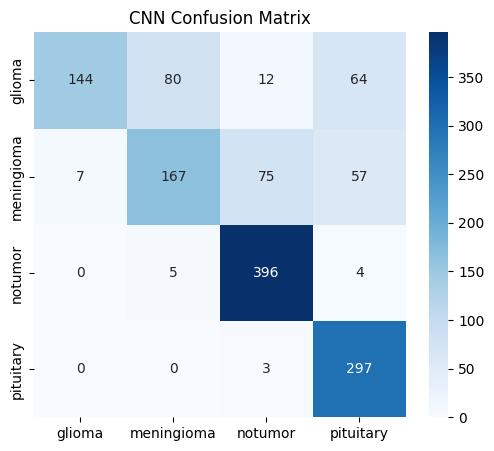

Evaluating AlexNet
41/41 ━━━━━━━━━━━━━━━━━━━━ 7s 153ms/step


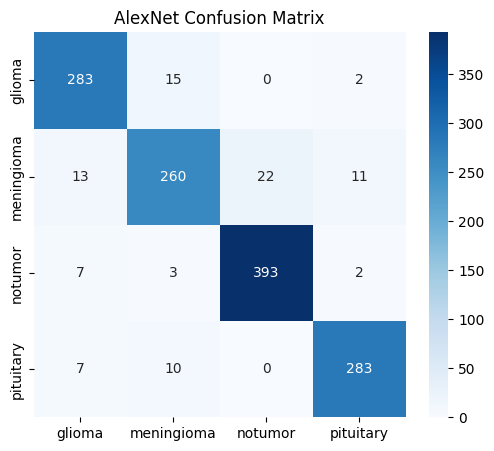

Evaluating ResNet50
41/41 ━━━━━━━━━━━━━━━━━━━━ 14s 249ms/step


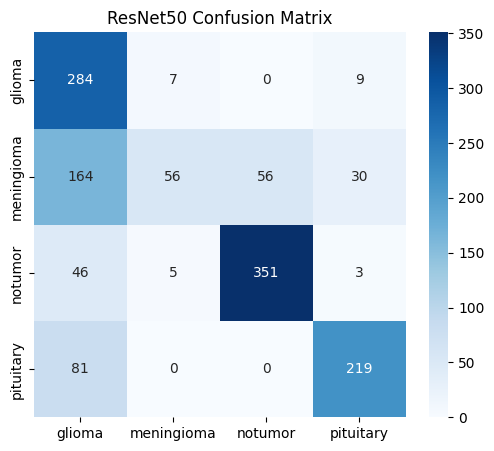

Evaluating MesResNet50
41/41 ━━━━━━━━━━━━━━━━━━━━ 12s 212ms/step


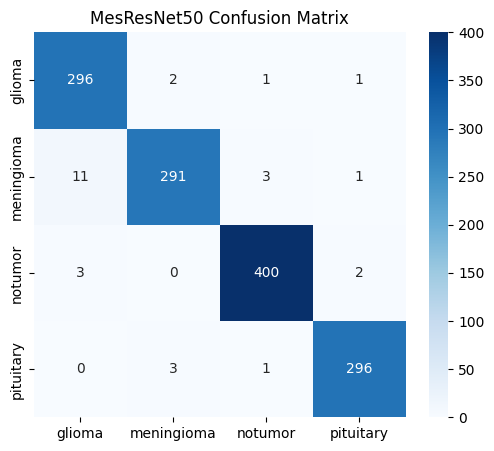

In [ ]:
# STEP 8: Evaluation & Metrics
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from sklearn.preprocessing import label_binarize
import pandas as pd

def evaluate_model(name, model):
    pred = model.predict(test_gen)
    y_pred = np.argmax(pred, axis=1)
    y_true = test_gen.classes
    report = classification_report(y_true, y_pred, output_dict=True)
    cm = confusion_matrix(y_true, y_pred)


    # Save confusion matrix
    plt.figure(figsize=(6,5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=test_gen.class_indices, yticklabels=test_gen.class_indices)
    plt.title(f'{name} Confusion Matrix')
    plt.savefig(f"{save_dir}/{name}_conf_matrix.png")
    plt.show()
    plt.close()

    # ROC Curve (binary/multiclass one-vs-rest)
    y_true_bin = label_binarize(y_true, classes=list(range(num_classes)))
    fpr, tpr, _ = roc_curve(y_true_bin.ravel(), pred.ravel())
    roc_auc = auc(fpr, tpr)

    return {
        "accuracy": report['accuracy'],
        "precision": np.mean([report[str(i)]['precision'] for i in range(num_classes)]),
        "recall": np.mean([report[str(i)]['recall'] for i in range(num_classes)]),
        "f1_score": np.mean([report[str(i)]['f1-score'] for i in range(num_classes)]),
        "roc_auc": roc_auc,
        "probs": pred
    }

results = {}
probs_dict = {}

for name, model in models_dict.items():
    print(f"Evaluating {name}")
    eval_res = evaluate_model(name, model)
    results[name] = {k:v for k,v in eval_res.items() if k!="probs"}
    probs_dict[name] = eval_res["probs"]

Evaluating Soft Voting Ensemble...


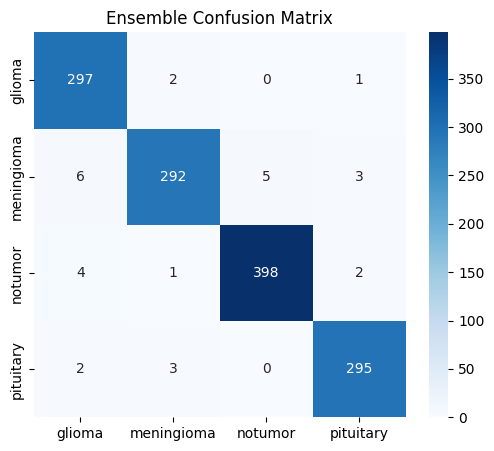

In [ ]:
# STEP 9: Soft Voting Ensemble (AlexNet + MesResNet50)
print("Evaluating Soft Voting Ensemble...")
ensemble_probs = (probs_dict["AlexNet"] + probs_dict["MesResNet50"]) / 2.0
y_pred = np.argmax(ensemble_probs, axis=1)
y_true = test_gen.classes
report = classification_report(y_true, y_pred, output_dict=True)
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=test_gen.class_indices, yticklabels=test_gen.class_indices)
plt.title('Ensemble Confusion Matrix')
plt.savefig(f"{save_dir}/Ensemble_conf_matrix.png")
plt.show()
plt.close()

y_true_bin = label_binarize(y_true, classes=list(range(num_classes)))
fpr, tpr, _ = roc_curve(y_true_bin.ravel(), ensemble_probs.ravel())
roc_auc = auc(fpr, tpr)

results["Ensemble"] = {
    "accuracy": report['accuracy'],
    "precision": np.mean([report[str(i)]['precision'] for i in range(num_classes)]),
    "recall": np.mean([report[str(i)]['recall'] for i in range(num_classes)]),
    "f1_score": np.mean([report[str(i)]['f1-score'] for i in range(num_classes)]),
    "roc_auc": roc_auc
}


             accuracy  precision    recall  f1_score   roc_auc
CNN          0.765828   0.783737  0.748382  0.737188  0.925779
AlexNet      0.929825   0.928083  0.926678  0.927079  0.992743
ResNet50     0.694127   0.754733  0.681585  0.648472  0.902066
MesResNet50  0.978642   0.978067  0.977992  0.977898  0.997631
Ensemble     0.977879   0.977173  0.977574  0.977276  0.998922


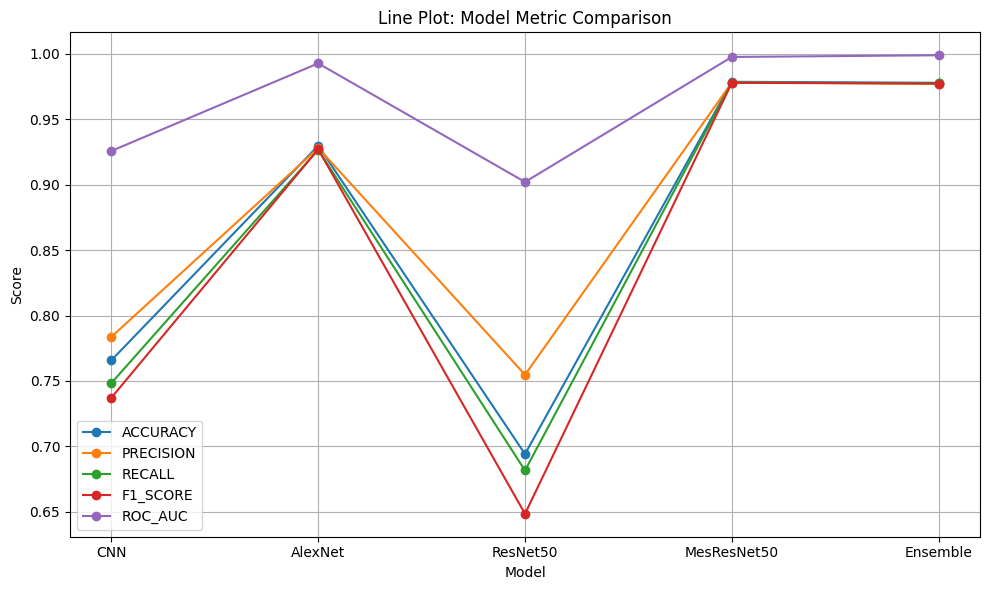

In [ ]:
# STEP 10: Save Results & Plots
df_results = pd.DataFrame(results).T
df_results.to_csv(f"{save_dir}/model_comparison.csv")
print(df_results)

# Line Plot
metrics_list = ["accuracy", "precision", "recall", "f1_score", "roc_auc"]
plt.figure(figsize=(10, 6))
for metric in metrics_list:
    plt.plot(df_results.index, df_results[metric], marker='o', label=metric.upper())
plt.title("Line Plot: Model Metric Comparison")
plt.xlabel("Model")
plt.ylabel("Score")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig(f"{save_dir}/lineplot_all_metrics.png")
plt.show()
plt.close()

# Bar Plots
for metric in metrics_list:
    plt.figure()
    df_results[metric].plot(kind='bar', title=f"{metric.upper()} Comparison", color='skyblue')
    plt.ylabel(metric)
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(f"{save_dir}/{metric}_comparison.png")
    plt.close()

In [ ]:
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

# Example: softmax probabilities from both models
# probs_alexnet.shape = (n_samples, n_classes)
# probs_mesresnet50.shape = (n_samples, n_classes)

# Assign weights (you can tune these)
w1 = 0.4  # weight for AlexNet
w2 = 0.6  # weight for MesResNet50

# Weighted average of probabilities
probs_ensemble = (w1 * probs_dict["AlexNet"]) + (w2 * probs_dict["MesResNet50"])

# Final prediction
y_pred_ensemble = np.argmax(probs_ensemble, axis=1)

# Evaluate
print("Accuracy:", accuracy_score(y_true, y_pred_ensemble))
print("Precision:", precision_score(y_true, y_pred_ensemble, average="weighted"))
print("Recall:", recall_score(y_true, y_pred_ensemble, average="weighted"))
print("F1 Score:", f1_score(y_true, y_pred_ensemble, average="weighted"))
print("ROC-AUC:", roc_auc_score(y_true, probs_ensemble, multi_class="ovr"))

NameError: name 'probs_dict' is not defined